# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *

In [4]:
config = mlm_config();

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
data_save_name = 'musicitem_data_save.pkl'

## MSKLM

In [6]:
data = load_data(numpy_path, data_save_name, bs=1)
vocab = data.vocab
learn = multitask_model_learner(data, config.copy())

## Load existing

In [7]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [8]:
load_path = saved_models[1];
learn.load(load_path.stem);
load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

### Predictions - Get midi file

In [9]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [10]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [11]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

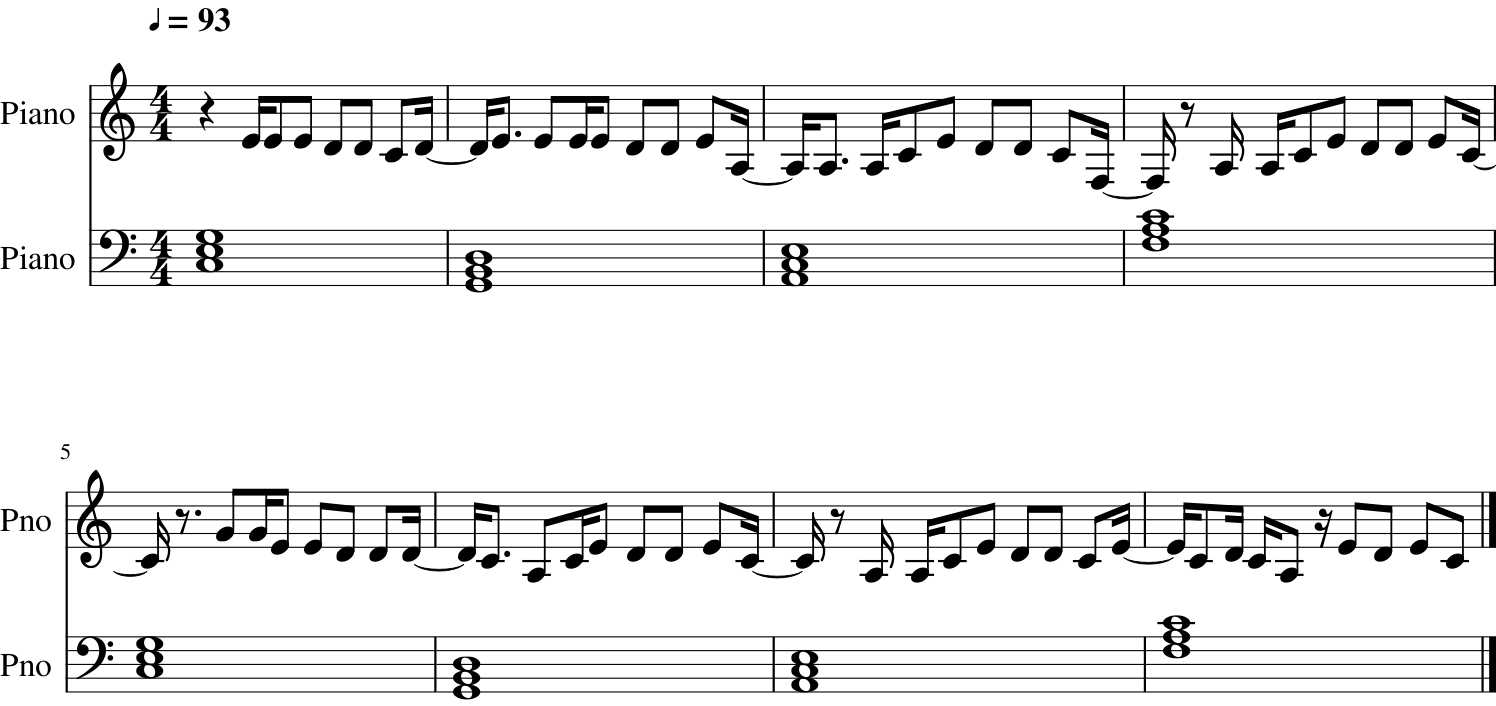

In [12]:
item.show()

In [13]:
item.play()

## Predict Mask

#### Regenerate durations

In [14]:
# duration mask
dur_item = item.mask_duration()

In [15]:
dur_pred = learn.predict_mask(dur_item, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

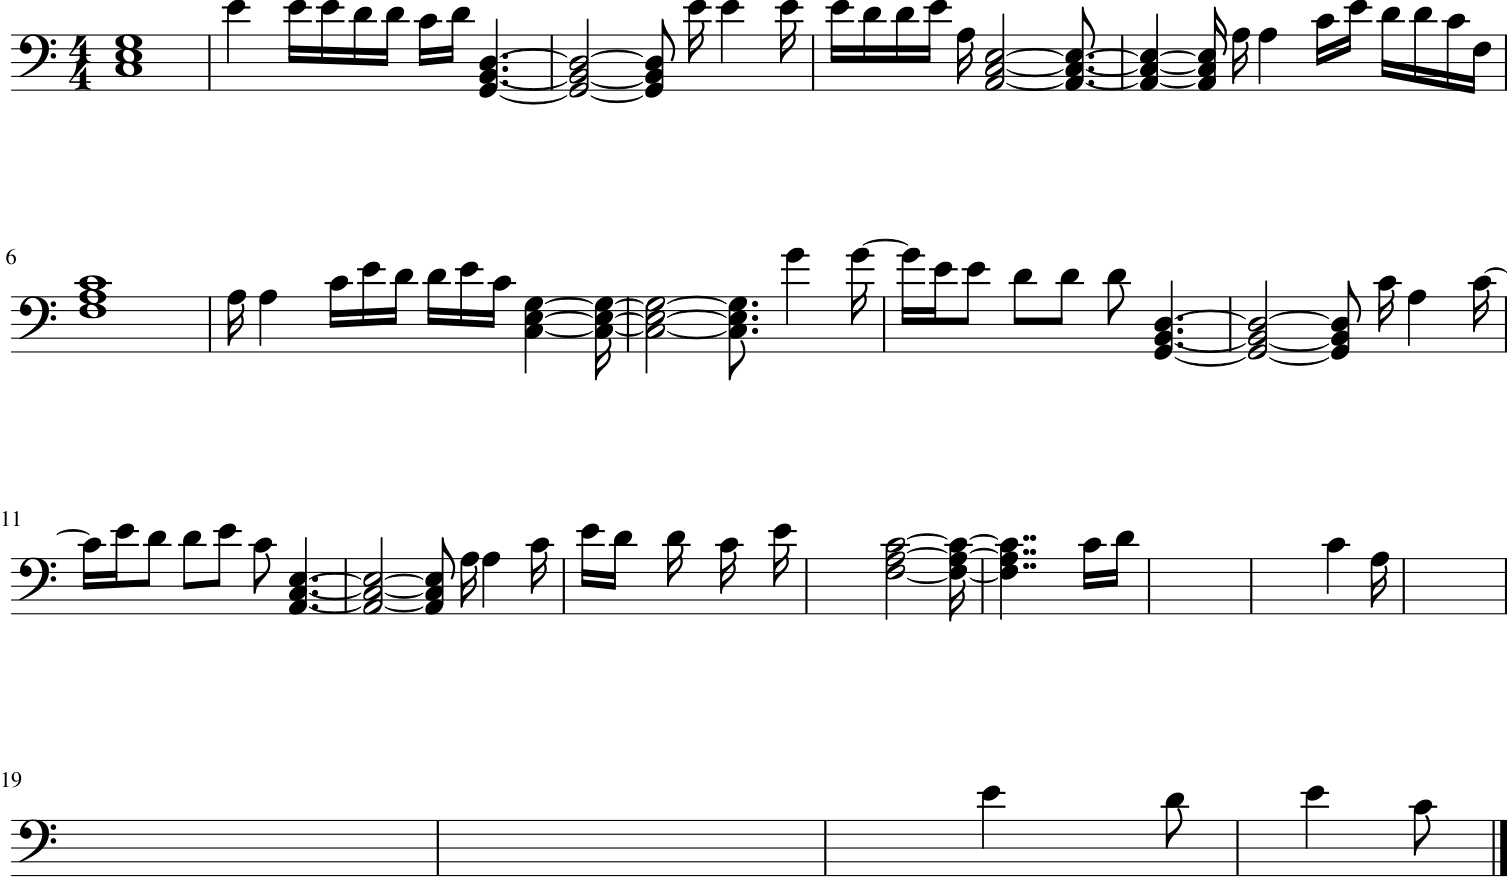

In [16]:
dur_pred.show()

#### Regenerate Notes

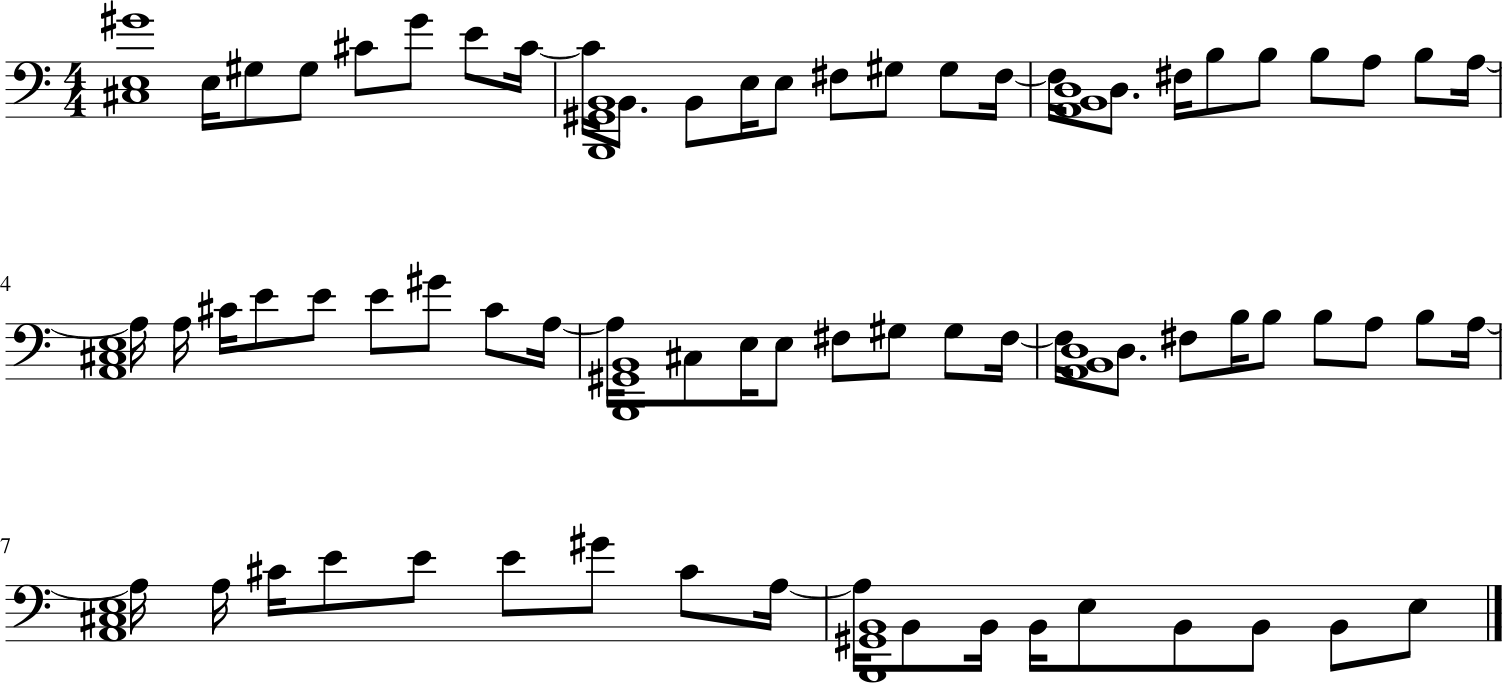

In [17]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
note_item = item.mask_notes()
pred_note = learn.predict_mask(note_item)

pred_note.show()

In [18]:
pred_note.play()

In [19]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

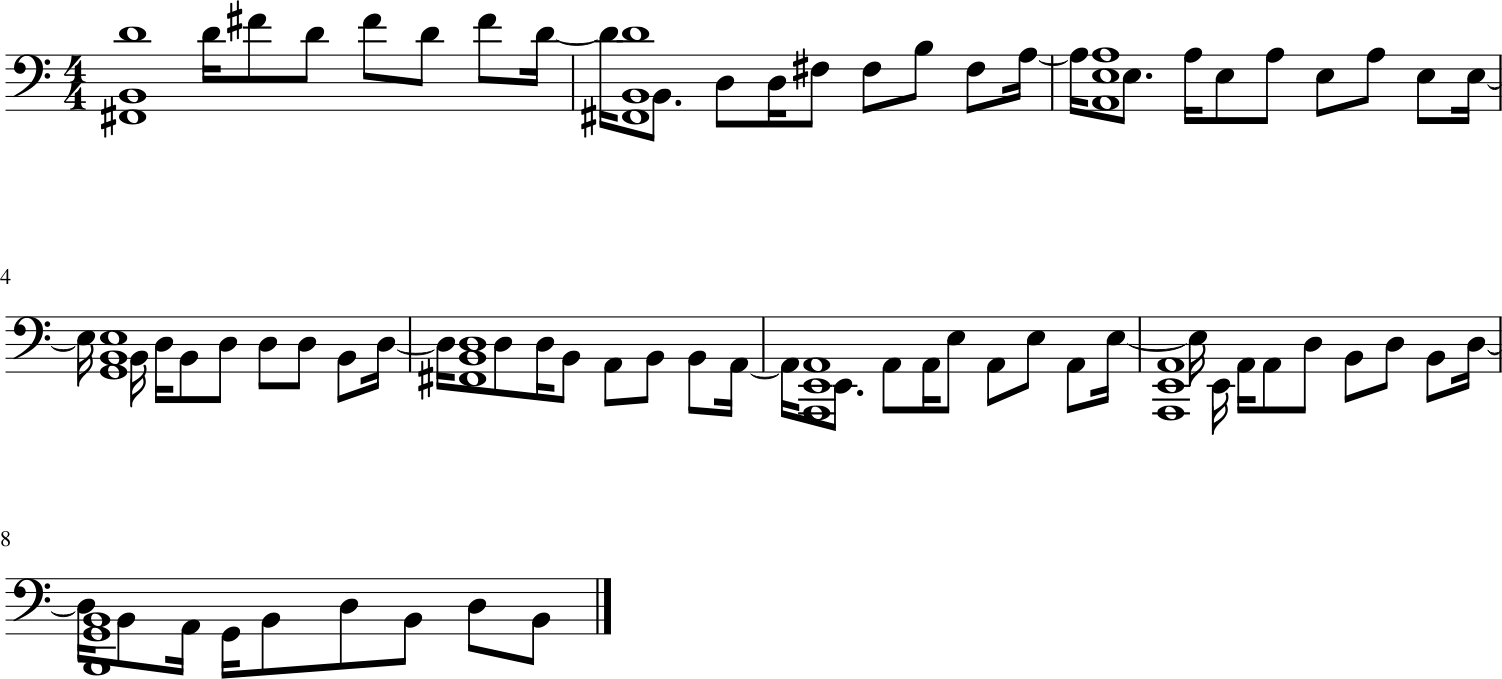

In [20]:
out.show()

## Prediction next word

In [21]:
seed_len = 4 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

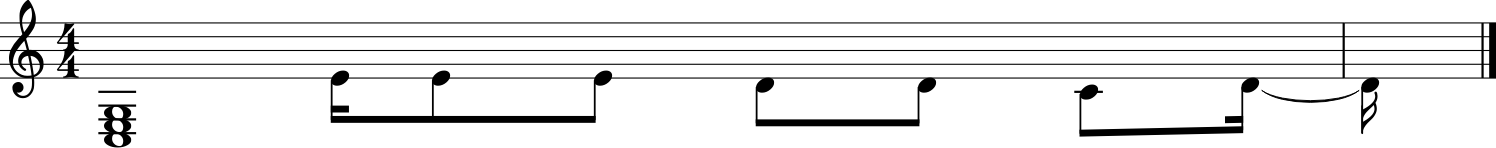

In [22]:
seed.show()

In [23]:
pred_nw = learn.predict_nw(seed, n_words=200)

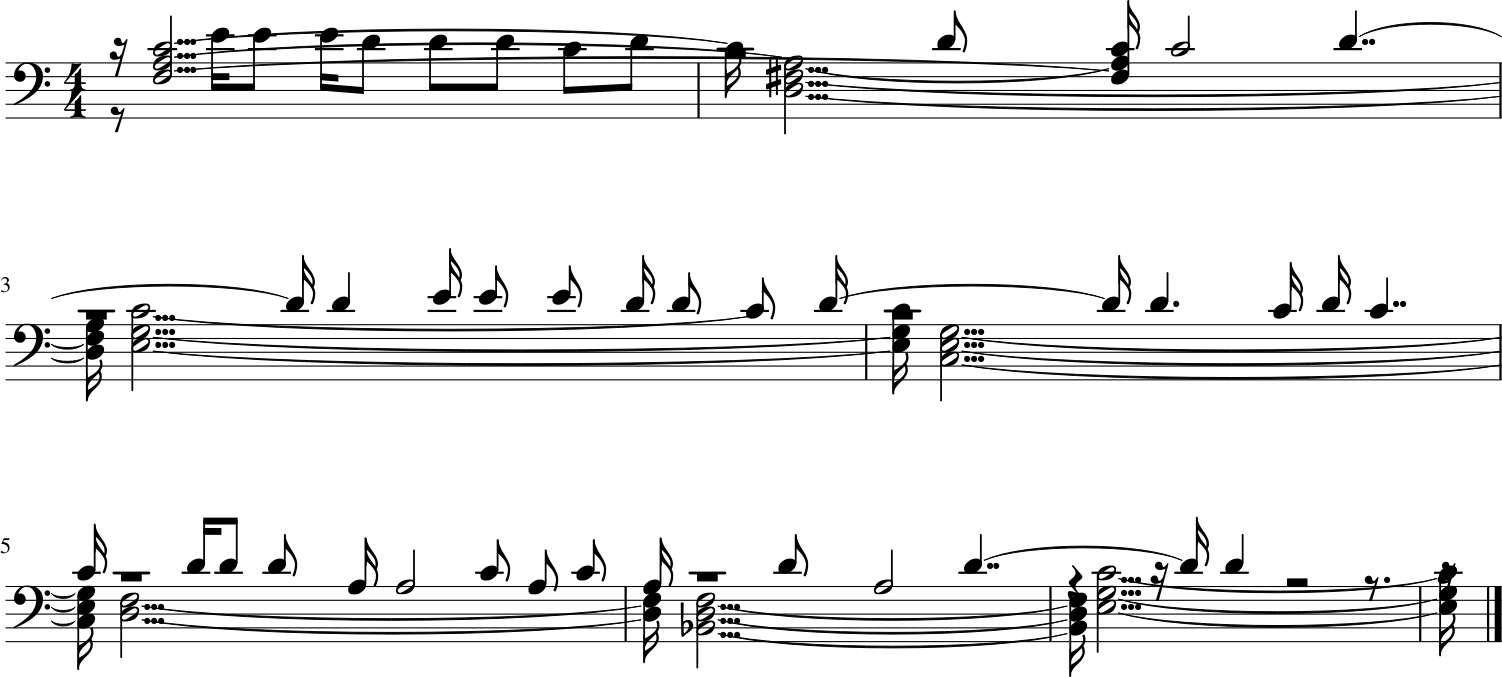

In [24]:
pred_nw.show()

In [25]:
pred_nw.play()

Convenience function

In [26]:
out = nw_predict_from_midi(learn, file, seed_len=seed_len, top_k=30, top_p=0.5)

Predicted BOS token. Returning prediction...


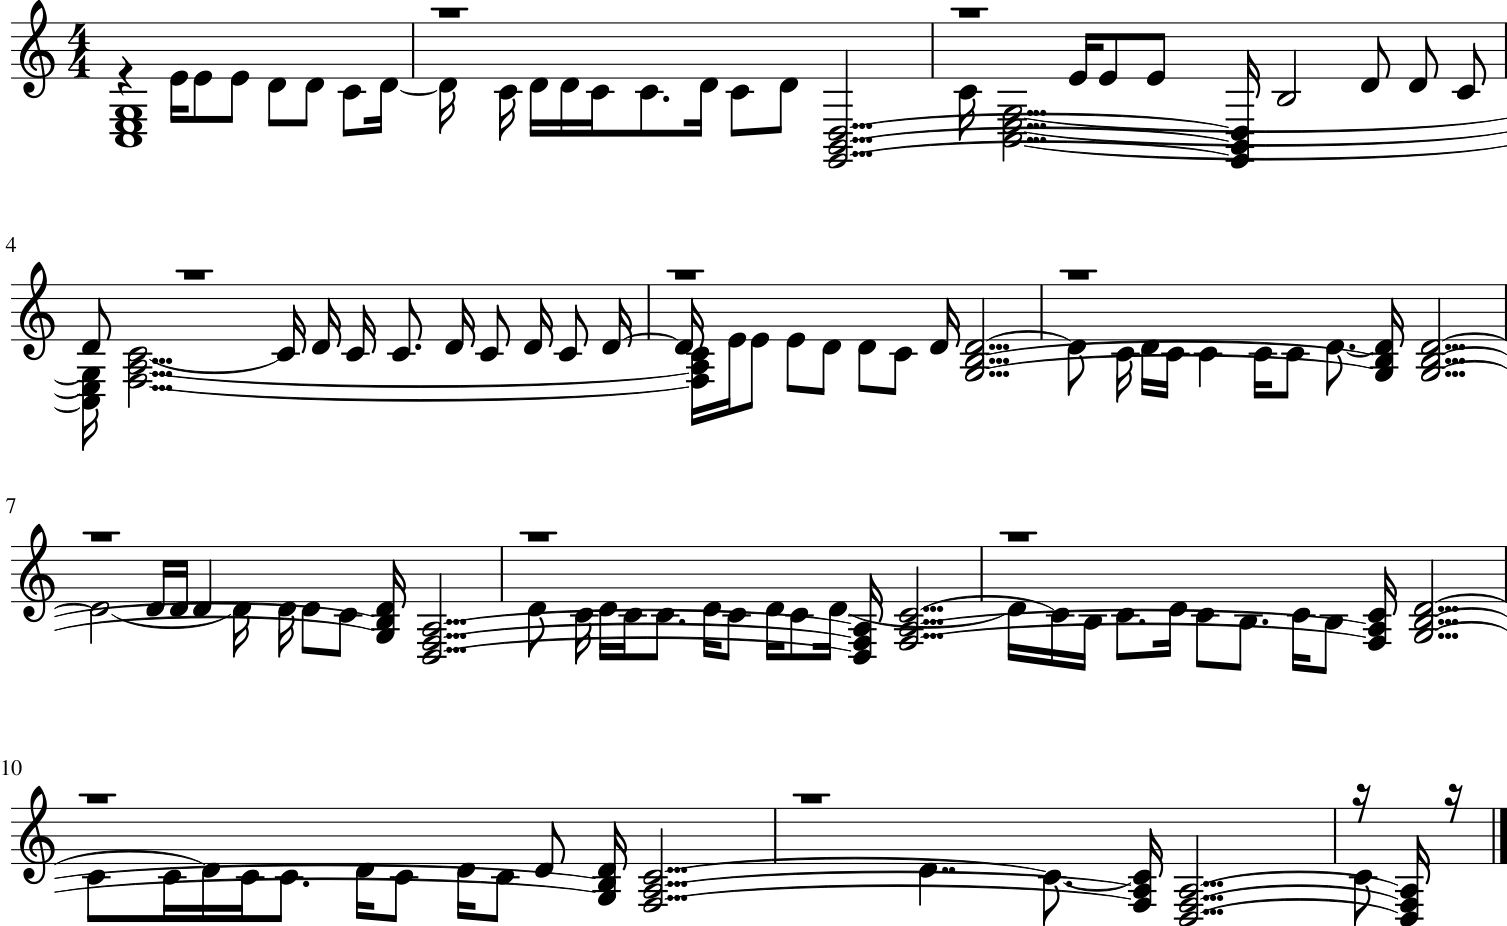

In [27]:
out.show()

## Predict Seq2Seq

In [28]:
from src.numpy_encode import stream2npenc_parts

In [29]:
multitrack_item = MultitrackItem.from_file(file, vocab)

In [30]:
melody, chords = multitrack_item.melody, multitrack_item.chords

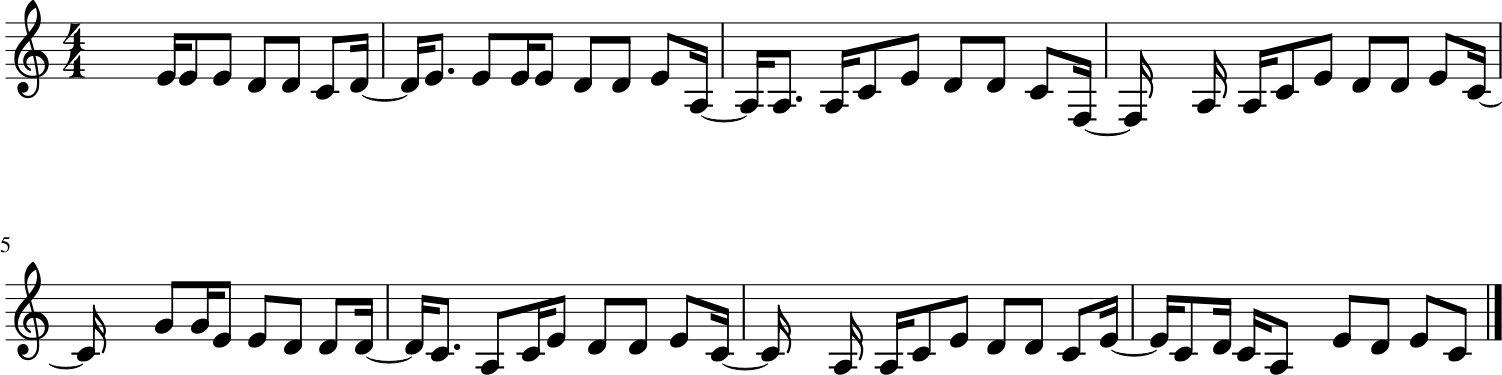

In [31]:
melody.show()

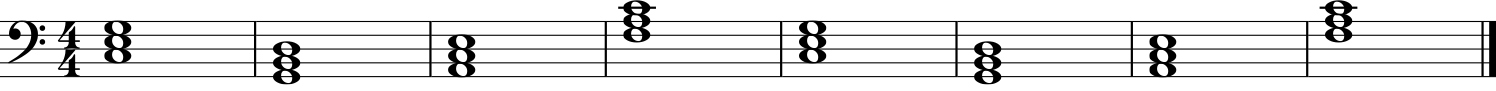

In [32]:
chords.show()

In [33]:
multitrack_item.play()

## Predict melody

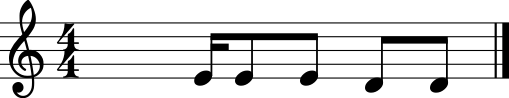

In [65]:
partial_melody = melody.trim_to_beat(3)
partial_melody.show()

Predicted past counter-part length. Returning early


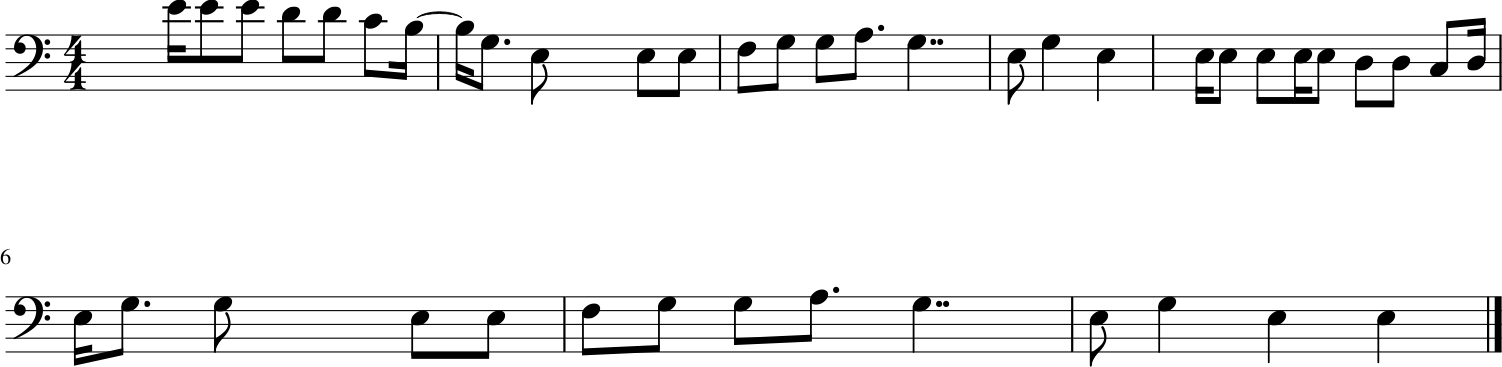

In [69]:
pred_melody = learn.predict_s2s(chords, partial_melody, use_memory=True)
pred_melody.show()

In [70]:
pred_melody.play()

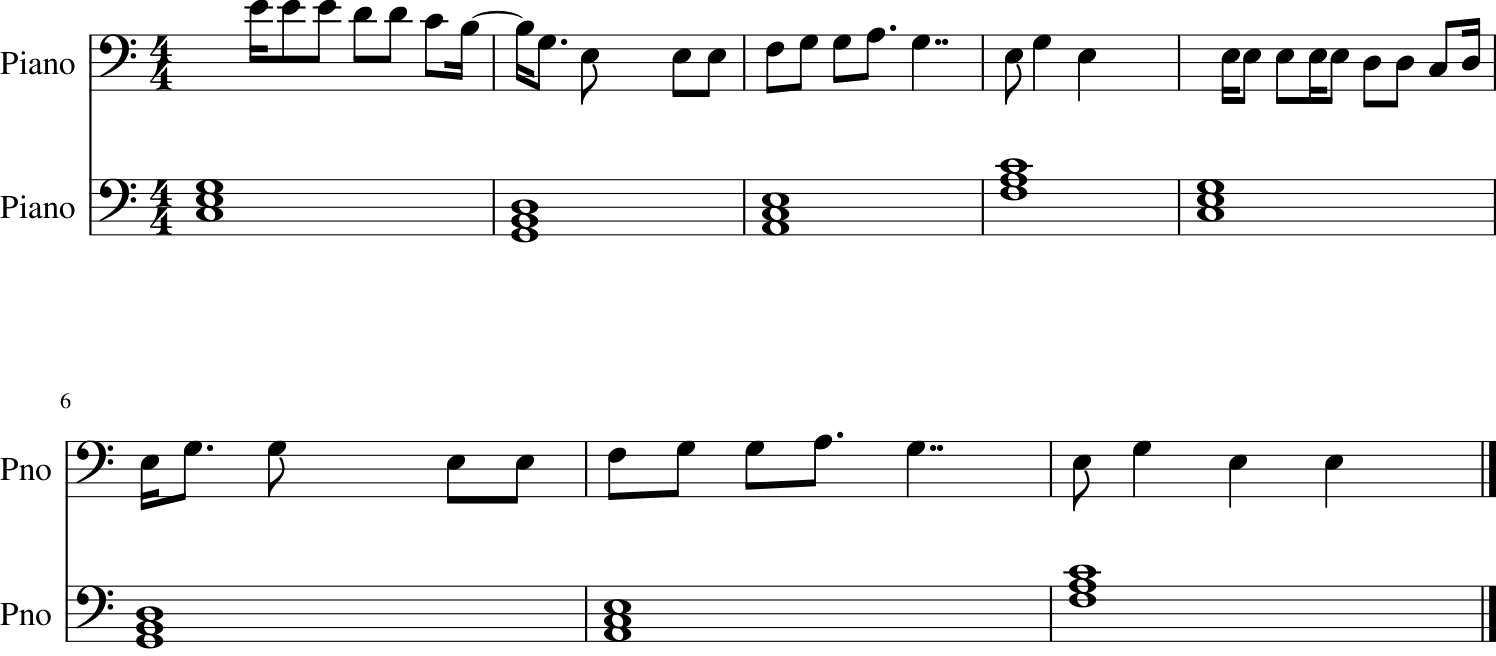

In [76]:
combined = MultitrackItem(pred_melody, chords)
combined.show()

In [77]:
combined.play()

## Predict chords

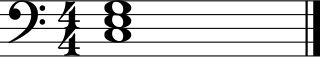

In [78]:
partial_chords = chords.trim_to_beat(3);
partial_chords.show()

In [79]:
pred_chord = learn.predict_s2s(input_item=melody, target_item=partial_chords)

Predicted past counter-part length. Returning early


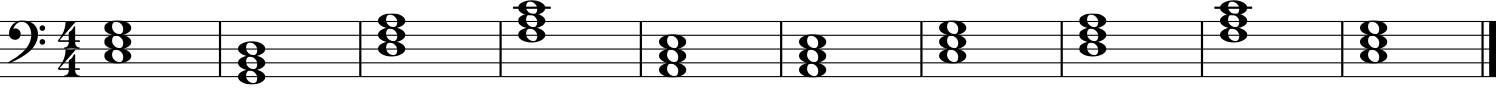

In [80]:
pred_chord.show()

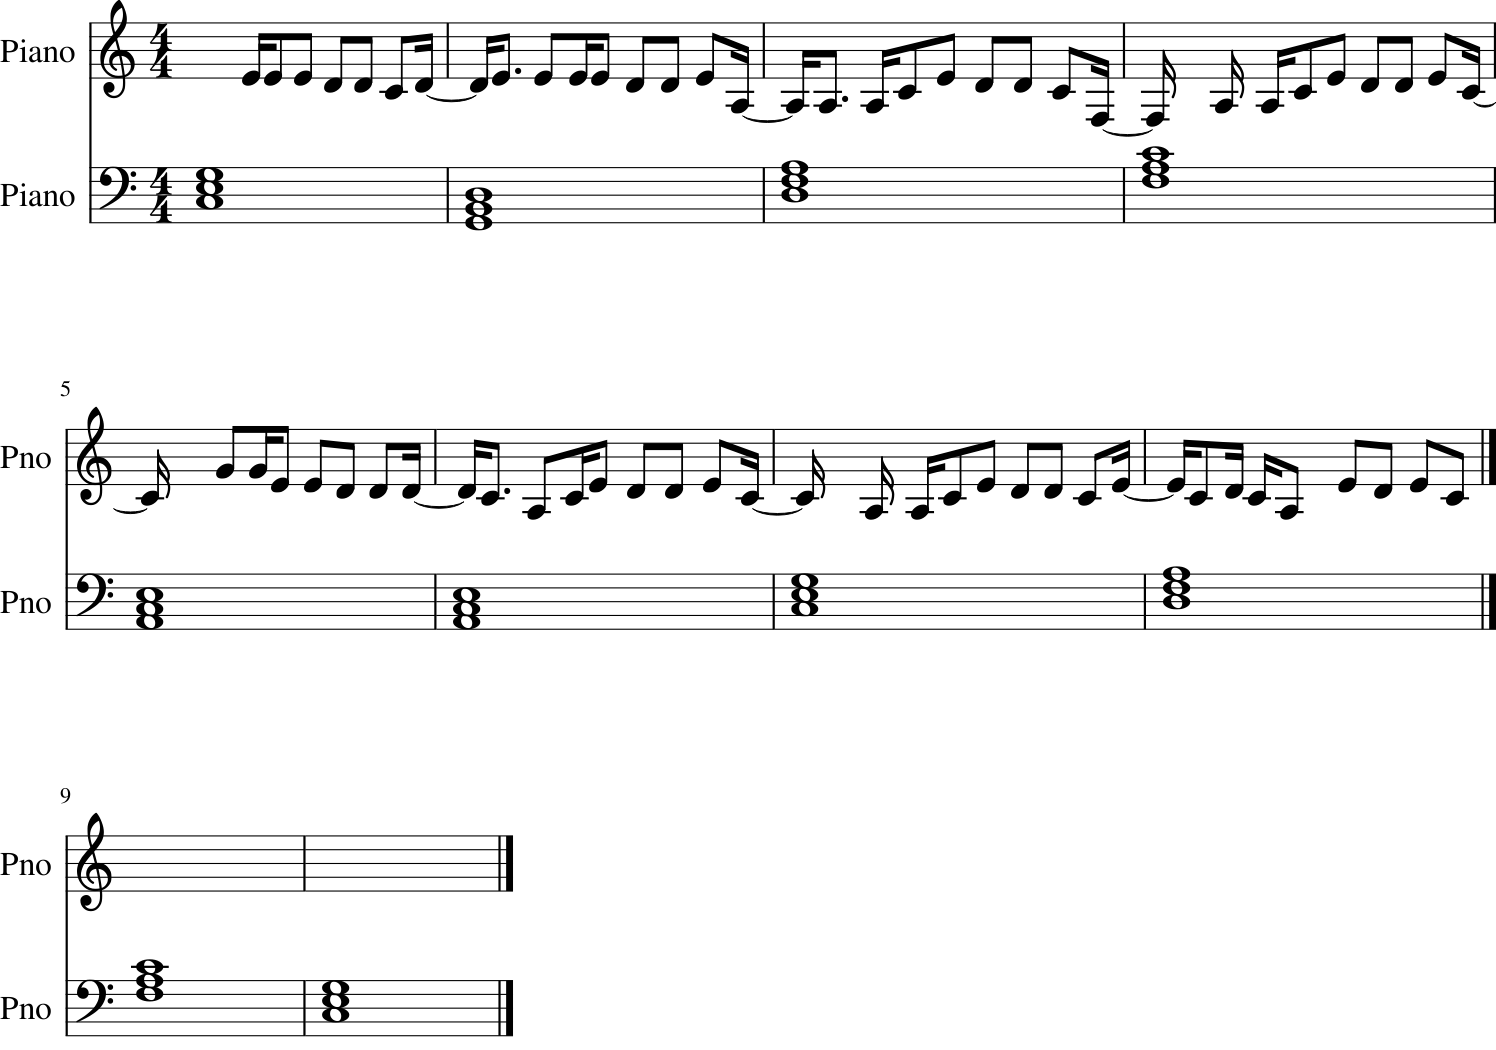

In [81]:
combined = MultitrackItem(melody, pred_chord)
combined.show()

Convenience Function

In [82]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 8 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


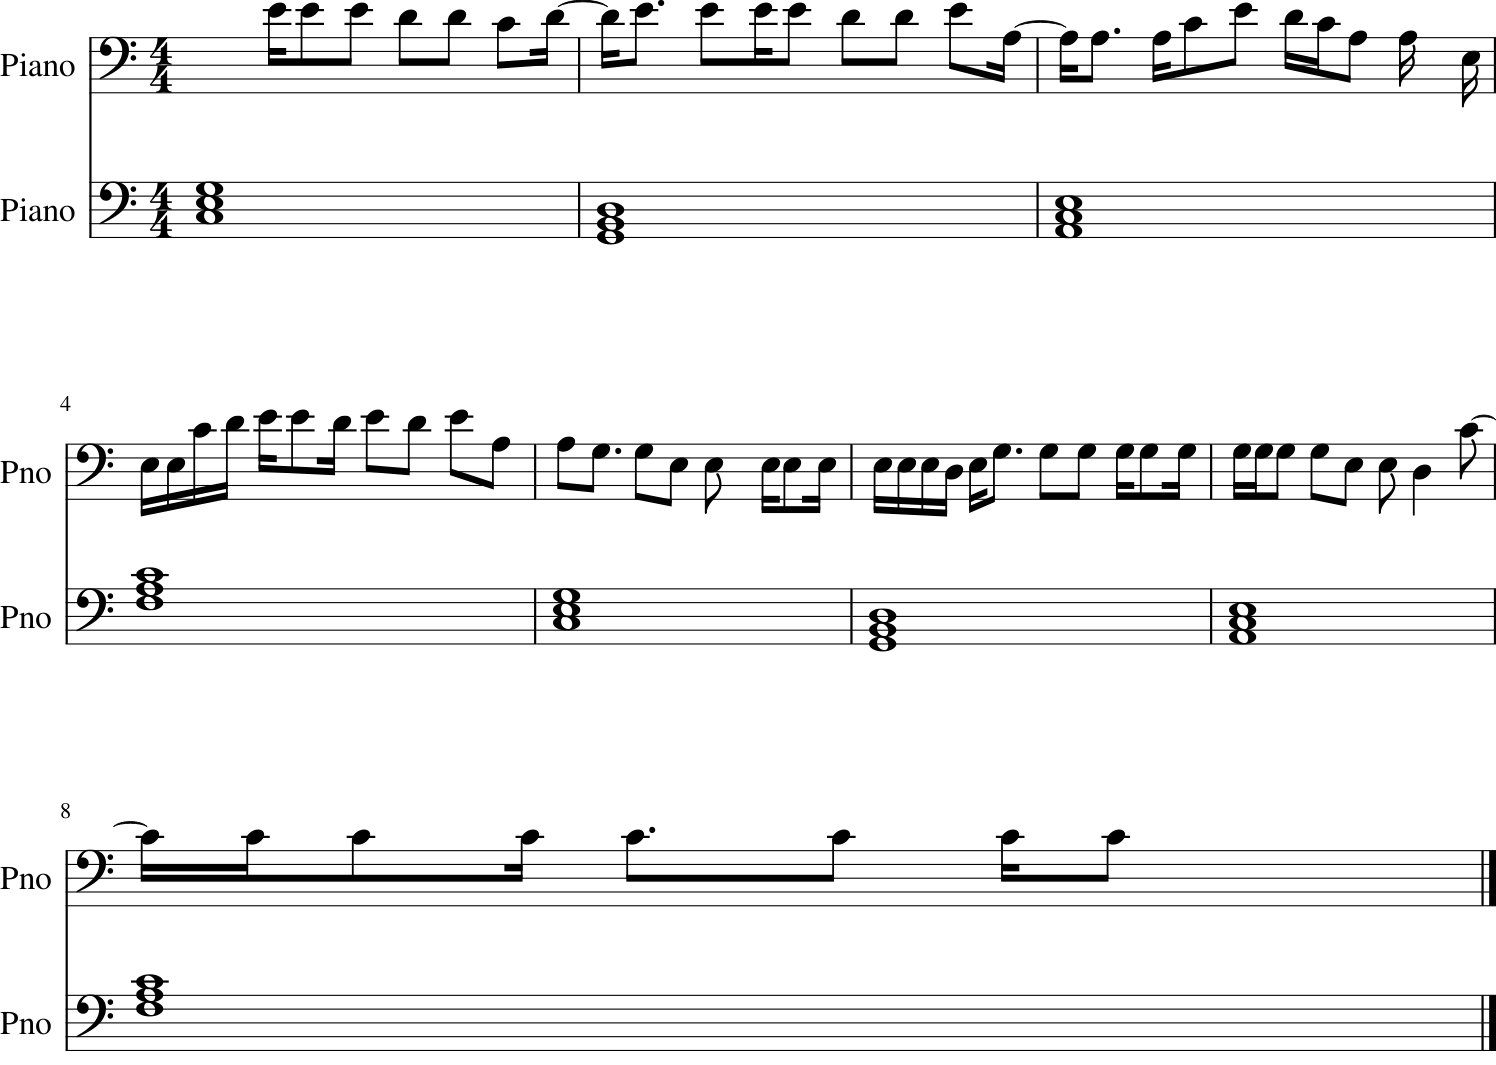

In [83]:
out.show()